# Deep Learning Mini-Challenge 1: Image Classification

**Author**: Lukas Reber

**Task**: Train a neural network to classify images from the CIFAR-10 dataset. Focus will be on the training and evaluation of the model, not on the data preprocessing. We will use PyTorch to implement a Multi Layer Perceptron (MLP) and a Convolutional Neural Network (CNN) to classify images the images.

**Dataset**: The [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images. The dataset is divided into five training batches and one test batch, each with 10,000 images. The test batch contains exactly 1,000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5,000 images from each class.

## Import dependencies & load data

In [1]:
import torch
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import wandb
from datetime import datetime
import pandas as pd
import seaborn as sns
import os
from torchsummary import summary

## Weights & Biases initialization

In order to keep track of the training process, we will use the Weights & Biases Library, which will allow us to log the training process and visualize the results.

In [2]:
# login to w&b
wandb.login()

os.environ["WANDB_SILENT"] = "True"

wandb: Currently logged in as: lukasreber (lukas_fhnw). Use `wandb login --relogin` to force relogin


## GPU Setup

Model Training is done locally on a GPU. Since I'm using a Macbook Pro, I can access the GPU via "MPS". If you are using a different operating system, you might need to install the CUDA toolkit.

In [3]:
# check if gpu support on the m1 mac or cuda is available
if torch.backends.mps.is_available() & torch.backends.mps.is_built():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

mps


## Ensure Reproducibility

For reproducibility, we will set the random seed to a fixed value.

In [4]:
# ensure deterministic behavior
torch.manual_seed(10)
np.random.seed(10)

## Load Data

We can directly load the CIFAR-10 dataset from PyTorch's `torchvision` package. Since the data consists of images or range [0,255], we normalize the data to range [0,1]. (RGB values range from 0-255, therefore by dividing by 255 we normalize the data to range [0,1].)

In [5]:
# load the data and normalize it

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifar_train = CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar_test = CIFAR10(root='./data', train=False, download=True, transform=transform)

print(f'Shape: {cifar_train.data.shape}')

Files already downloaded and verified
Files already downloaded and verified
Shape: (50000, 32, 32, 3)


# Explorative Data Analysis

From the previous output, we can see that there are 50'000 training images. Each image has three layers (RGB) and 32x32 pixels each. We can look at some random images from the training set to get a better idea of the data.

Due to the fact, that the RGB values have already been normalized, we can see that the images are quite dark.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

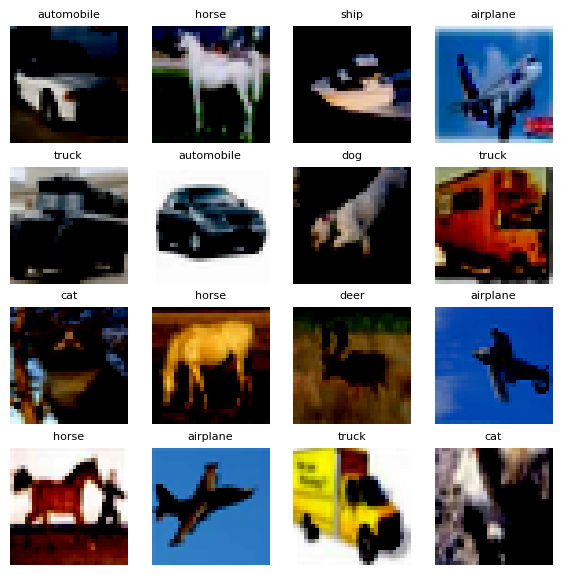

In [7]:
# plot sample images
rand_idx = np.random.randint(0, len(cifar_train), 16)
fig, axs = plt.subplots(4,4, figsize=(7,7))
for i, ax in enumerate(axs.flat):
    ax.imshow(cifar_train[rand_idx[i]][0].permute(1,2,0))
    ax.set_title(cifar_train.classes[cifar_train[rand_idx[i]][1]], size=8)
    ax.axis('off')
plt.show()

## Class Distribution

We would also like to see if there is class imbalance. Class imbalance is a problem in machine learning, where the number of samples in one class is significantly higher than the number of samples in another class. This can lead to a model that is biased towards the class with more samples.

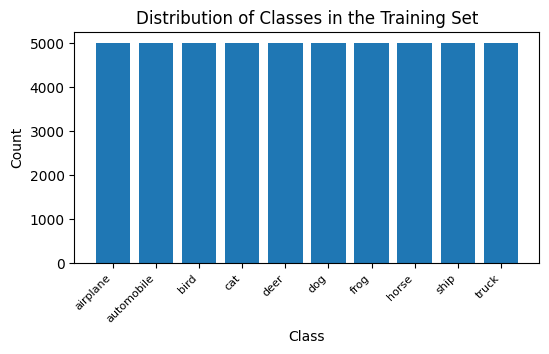

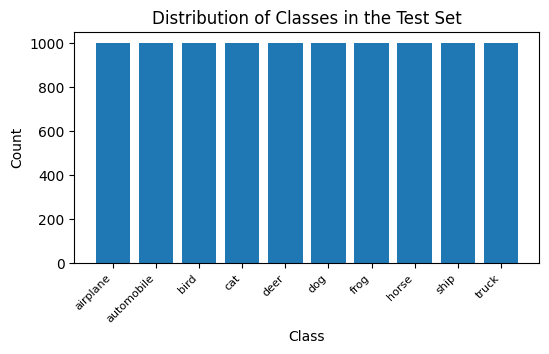

In [8]:
# display distribution of classes
values, counts = np.unique(cifar_train.targets, return_counts=True)

fig, ax = plt.subplots(1,1, figsize=(6,3))
ax.bar(values, counts)
ax.set_title('Distribution of Classes in the Training Set')
ax.set_ylabel('Count')
ax.set_xlabel('Class')
ax.set_xticks(values)
ax.set_xticklabels(cifar_train.classes, rotation=45, ha='right', size=8)
plt.show()

values, counts = np.unique(cifar_test.targets, return_counts=True)

fig, ax = plt.subplots(1,1, figsize=(6,3))
ax.bar(values, counts)
ax.set_title('Distribution of Classes in the Test Set')
ax.set_ylabel('Count')
ax.set_xlabel('Class')
ax.set_xticks(values)
ax.set_xticklabels(cifar_test.classes, rotation=45, ha='right', size=8)
plt.show()

We can see that both the training and test set have a balanced distribution of classes. For Training, we have 5000 samples per class, and for the test set we have 1000 samples per class.

# Model Training

## Metrics

Now that we have loaded and verified the data, we need to define our training and evaluation functions.

We will use cross entropy loss as our loss function. Cross entropy loss is most commonly used for classification problems. A perfect model would have a cross entropy loss of 0. Therefore our goal is to minimize the loss during the training of the network. Cross entropy loss is defined as:

$$ Cross Entropy = - \frac{1}{N} \sum_{n=1}^{N} [y_n \log(\hat{y}_n) + (1-y_n) log(1-\hat{y}_n)] $$

where: 
- $N$ is the number of samples
- $y_n$ is the true label
- $\hat{y}_n$ is the predicted label

We will use accuracy as our evaluation metric. Accuracy is defined as:

$$ Accuracy = \frac{TP + TN}{TP + TN + FP + FN} = \frac{NumberOfCorrectPredictions}{TotalNumberOfPredictions} $$

Since we have 10 different classes in our dataset, our worst possible accuracy score should be 0.1 (or 10%). This is because if we were to predict the same class for every image, we would be correct 10% of the time. Therefore, our goal is to achieve an accuracy score higher than 10%.



## Define Model Training Function

The function "model_training" will train the model for a given number of epochs and logs the training process to Weights & Biases.

In [31]:
def calc_true(pred, labels):
    pred_labels = torch.argmax(pred, dim=1)
    return (pred_labels == labels).float().sum()

def model_eval(model, data, device):
    correct = 0
    total = 0
    with torch.no_grad():
        for d in data:
            x_test, y_test = d[0].to(device), d[1].to(device)
            outputs = model(x_test)
            _, predicted = torch.max(outputs.data, 1)
            total += y_test.size(0)
            correct += (predicted == y_test).sum().item()
    
    return correct / total

def model_training(modelclass, optimizer, traindata, testdata, criterion, epochs, device, name):

    model = modelclass()
    model = model.to(device)
    optimizer = optimizer(model)

    # wand watch not yet supportet for mps devices
    if device.type != 'mps':
       wandb.watch(model, criterion, log="all")

    for epoch in range(epochs):
        train_acc = 0
        # running_loss = 0.0
        for i, data in enumerate(traindata, 0):
            # get the inputs
            inputs, labels = data[0].to(device), data[1].to(device)
            
            # forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # backward pass + zero the parameter gradients
            optimizer.zero_grad()
            loss.backward()

            # step with optimizer
            optimizer.step()

            # statistics
            train_acc += calc_true(outputs, labels)
            wandb.log({'loss': loss.item()})

        epoch_test_acc = train_acc.item() / len(traindata.dataset)
        epoch_train_acc = model_eval(model, testdata, device)

        wandb.log({'train_acc': epoch_test_acc, 'test_acc': epoch_train_acc})

    # save the model
    torch.save(model, f'./models/{name}.pth')


## Define Evaluation Functions

We defined two different functions in order to evaluate our trained models. The first function "get_logs" will return the recorded evaluation metrics from the given sweep. The second function "plot_results" will plot the results of the sweep.

In [7]:
def get_logs(sweep_id):
    api = wandb.Api()

    # get a sweep
    sweep = api.sweep(f"lukas_fhnw/del_mc1/sweeps/{sweep_id}")

    # get all runs for a sweep
    runs = list(sweep.runs)

    names = pd.DataFrame([run.name for run in runs])

    # define the keys to extract from the summary
    summary_keys = ['_step','_runtime','_timestamp','test_acc', 'train_acc', 'loss']
    # extract values for each run and create a dataframe
    summaries = pd.DataFrame([{ key:value for key,value in run.summary.items() if key in summary_keys} for run in runs])
    #merge the names into the summaries
    summaries = pd.concat([names, summaries], axis=1)
    summaries.rename(columns={0:'run'}, inplace=True)
    
    # extract all config values for each run and create a dataframe
    configs = pd.DataFrame([run.config for run in runs])
    #merge the names into the configs
    configs = pd.concat([names, configs], axis=1)
    configs.rename(columns={0:'run'}, inplace=True)

    # extract all history values for each run and create a dataframe
    accuracies = pd.DataFrame()
    losses = pd.DataFrame()
    for run in runs:
        acc = run.history(keys=['train_acc', 'test_acc'])
        # acc = pd.DataFrame([row for row in acc])
        acc['run'] = run.name
        accuracies = pd.concat([accuracies, acc])

        loss = run.history(keys=['loss'])
        # loss = pd.DataFrame([row for row in loss])
        loss['run'] = run.name
        losses = pd.concat([losses, loss])

    return summaries, configs, accuracies, losses

In [47]:
def plot_results(summaries, configs, accuracies, losses, lr_bsize, title):

    print(title)
    sns.set_style("white")

    # prepare data
    merged_data = pd.merge(summaries, configs, on='run')

    # plot results
    fig, axes = plt.subplots(2, figsize=(10,10))

    # Test Accuracy
    ax = sns.lineplot(data=accuracies, x='_step', y='test_acc', hue='run', ax=axes[0])
    ax.set(xlabel='Iterations')
    ax.title.set_text('Test Accuracy')
    ax.legend(loc='lower right', fontsize=8)

    # Train Accuracy
    ax2 = sns.lineplot(data=accuracies, x='_step', y='train_acc', hue='run', ax=axes[1])
    ax2.set(xlabel='Iterations')
    ax2.title.set_text('Train Accuracy')
    ax2.legend(loc='lower right', fontsize=8)

    best_run = merged_data.iloc[merged_data['test_acc'].idxmax()]

    # compare training and test accuracy on best run
    best_run_acc = accuracies[accuracies['run'] == best_run.run]
    best_run_loss = losses[losses['run'] == best_run.run]
    fig, axes = plt.subplots(figsize=(7,4))
    ax = sns.lineplot(data=best_run_loss, x='_step', y='loss', ax=axes, label='Loss', legend=None, color='#e77c8d')
    ax.set(xlabel='Epochs')
    ax2 = ax.twinx()
    sns.lineplot(data=best_run_acc, x='_step', y='test_acc', ax=ax2, label='Test Accuracy', legend=None , color='#56ad74')
    sns.lineplot(data=best_run_acc, x='_step', y='train_acc', ax=ax2, label='Train Accuracy', legend=None, color='#5c8bba')
    ax2.set(ylabel='Accuracy')
    ax.title.set_text('Accuracy/Loss on best performing run')
    ax.figure.legend()
    plt.show()

    # explain the results
    print(f'Best Test Accuracy: {best_run.test_acc}, with Batch Size {best_run.batch_size} and Learning Rate {best_run.learning_rate}, run: {best_run.run}' )

    # load model for summary info
    model = torch.load(f'./models/{best_run.run}.pth')
    model = model.to('cpu')
    print(summary(model, (3, 32, 32)))

    if lr_bsize:
        # Heatmap
        plot = sns.heatmap(pd.pivot_table(merged_data,index='batch_size',columns='learning_rate',values='test_acc',aggfunc='max'), annot=True)
        plot.set(xlabel='Learning Rate', ylabel='Batch Size')
        plot.title.set_text('Test Accuracy over Learning Rate & Batch Size')
        plt.show()
    

## Multi Layer Perceptron (MLP)

First we train two different MLP of varing size. The first network has 2 hidden layers with 128 and 64 neurons, respectively. The second network has 3 hidden layers with 256, 128 and 64 neurons, respectively. We use the ReLU activation function for the hidden layers and the softmax activation function for the output layer. In order to achieve normal distributed weights, we use Kaiming initialization.

In [9]:
# MLP Model definition
# These classes are use to define the different model architectures

# Model 1: MLP with 2 hidden layers
class MLP_1(nn.Module):
    
    def __init__(self, input_size, output_size, fc1_size, fc2_size):
        super(MLP_1, self).__init__()
        
        self.fc1 = nn.Linear(input_size, fc1_size)
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        self.fc2 = nn.Linear(fc1_size, fc2_size)
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')
        self.fc3 = nn.Linear(fc2_size, output_size)
        nn.init.kaiming_normal_(self.fc3.weight, nonlinearity='relu')

    def forward(self, x):
        x = x.view(-1, 32*32*3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
    
# Model 1: MLP with 3 hidden layers
class MLP_2(nn.Module):
    
    def __init__(self, input_size, output_size, fc1_size, fc2_size, fc3_size):
        super(MLP_2, self).__init__()
        
        self.fc1 = nn.Linear(input_size, fc1_size)
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        self.fc2 = nn.Linear(fc1_size, fc2_size)
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')
        self.fc3 = nn.Linear(fc2_size, fc3_size)
        nn.init.kaiming_normal_(self.fc3.weight, nonlinearity='relu')
        self.fc4 = nn.Linear(fc3_size, output_size)
        nn.init.kaiming_normal_(self.fc4.weight, nonlinearity='relu')

    def forward(self, x):
        x = x.view(-1, 32*32*3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

### Model initialization & training

The function in the following cell are used to initialize the model training. The respective function is called by the W&B sweep agent using the different hyperparameters. The function then initializes the model training and logs the results to W&B.

Due to the different number of hidden layers, the initialization of the model training is different, and therefore we need to define different functions for each model.

In [48]:
def train_mlp_1(config=None):
    with wandb.init(config=config) as run:

        config = wandb.config

        wandb.run.name=f'{config.architecture}_lr{config.learning_rate}_bs{config.batch_size}_{datetime.now().strftime("%Y-%m-%d-%H-%M-%S")}'

        if config.optimizer == 'sgd':
            optimizer = lambda model: torch.optim.SGD(model.parameters(), lr=config.learning_rate)
        elif config.optimizer == 'adam':
            optimizer = lambda model: torch.optim.Adam(model.parameters(), lr=config.learning_rate)

        model_training(
            modelclass=lambda: MLP_1(config.input_size, config.output_size, config.hidden_layers[0], config.hidden_layers[1]),
            optimizer=optimizer,
            traindata=torch.utils.data.DataLoader(cifar_train, batch_size=config.batch_size, shuffle=True),
            testdata=torch.utils.data.DataLoader(cifar_test, batch_size=config.batch_size, shuffle=True),
            criterion=nn.CrossEntropyLoss(),
            epochs=config.epochs,
            device=device,
            name=wandb.run.name
        )

    
sweep_config = {
    'name': 'MLP_sweep',
    'method': 'grid',
    'metric': {
        'name': 'loss',
        'goal': 'minimize'
    },
    'parameters': {
        'epochs': {
            'value': 10
            },
        'batch_size': {
            'values': [20, 50, 100, 200],
        },
        'learning_rate': {
            'values': [0.01, 0.1, 0.2]
        },
        'architecture': {
            'value': 'mlp'
        },
        'optimizer': {
            'value': 'sgd'
        },
        'loss': {
            'value': 'CrossEntropyLoss'
        },
        'activation': {
            'value': 'relu'
        },
        'hidden_layers': {
            'values': [(128, 64)]
        },
        'input_size': {
            'value': 32*32*3
        },
        'output_size': {
            'value': 10
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="del_mc1")
wandb.agent(sweep_id, function=train_mlp_1)


Create sweep with ID: qoj5mkb4
Sweep URL: https://wandb.ai/lukas_fhnw/del_mc1/sweeps/qoj5mkb4


MLP with 2 layers [128, 64]


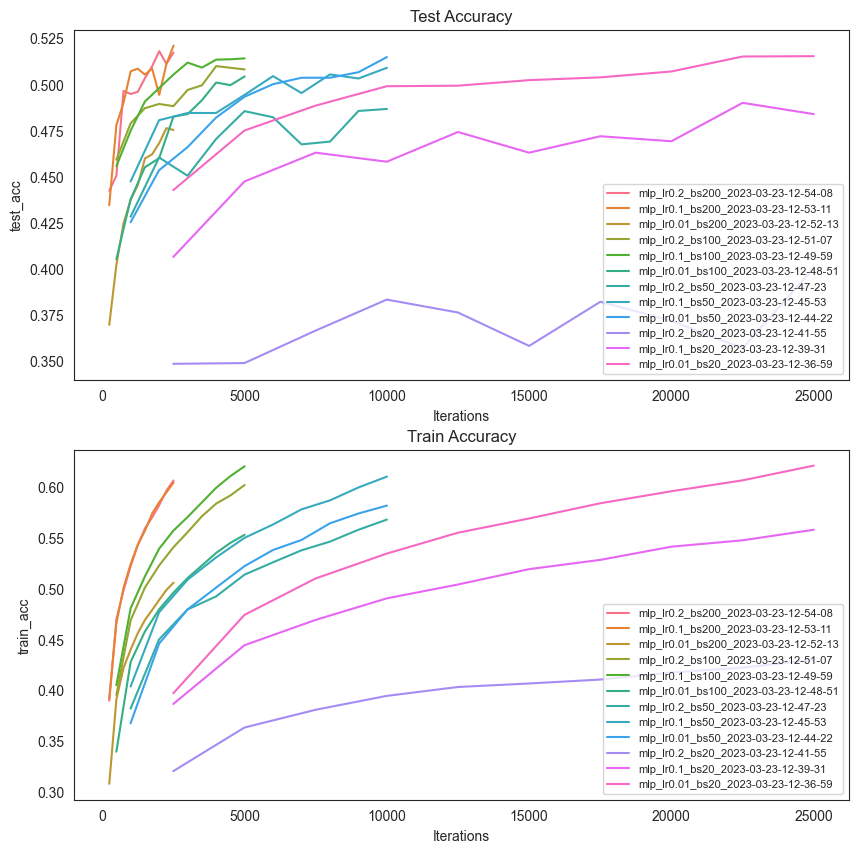

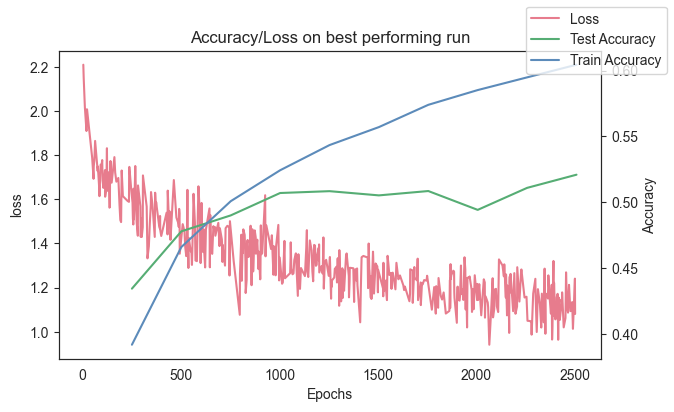

Best Test Accuracy: 0.521, with Batch Size 200 and Learning Rate 0.1


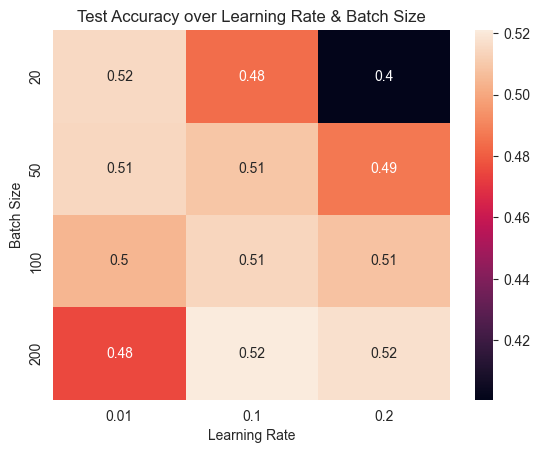

In [43]:
summary, configs, accuracies, losses = get_logs('7nhvg1tm')
nr_layers = len(configs.loc[0,'hidden_layers']) 
layers = configs.loc[0,'hidden_layers']
plot_results(summary, configs, accuracies, losses, True, f'MLP with {nr_layers} layers {layers}')

We trained a simple two layer MLP with 128 and 64 neurons. Our input size was 3072 (32x32x3), therefore our total number of parameters is:

- 1st layer: 32x32x3x128 + 128 = 393,344
- 2nd layer: 128x64 + 64 = 8,256
- Output layer: 64x10 + 10 = 650
- Total paremeter: 402,250

We can see that we receive better accuracy scores with when batch size or learning rate are both small or both large. If only batch size or learning rate is increased, the model performs worse. This is due to the fact that the model is not able to learn the data properly. If the batch size is too small, the model is not able to learn the data properly. If the learning rate is too large, the model is not able to converge to the global minimum.

In [13]:
def train_mlp_2(config=None):
    with wandb.init(config=config) as run:

        config = wandb.config

        wandb.run.name=f'{config.architecture}_lr{config.learning_rate}_bs{config.batch_size}_{datetime.now().strftime("%Y-%m-%d-%H-%M-%S")}'

        if config.optimizer == 'sgd':
            optimizer = lambda model: torch.optim.SGD(model.parameters(), lr=config.learning_rate)
        elif config.optimizer == 'adam':
            optimizer = lambda model: torch.optim.Adam(model.parameters(), lr=config.learning_rate)

        model_training(
            modelclass=lambda: MLP_2(config.input_size, config.output_size, config.hidden_layers[0], config.hidden_layers[1], config.hidden_layers[2]),
            optimizer=optimizer,
            traindata=torch.utils.data.DataLoader(cifar_train, batch_size=config.batch_size, shuffle=True),
            testdata=torch.utils.data.DataLoader(cifar_test, batch_size=config.batch_size, shuffle=True),
            criterion=nn.CrossEntropyLoss(),
            epochs=config.epochs,
            device=device
        )

sweep_config = {
    'name': 'MLP_sweep',
    'method': 'grid',
    'metric': {
        'name': 'loss',
        'goal': 'minimize'
    },
    'parameters': {
        'epochs': {
            'value': 10
            },
        'batch_size': {
            'values': [20, 50, 100, 200],
        },
        'learning_rate': {
            'values': [0.01, 0.1, 0.2]
        },
        'architecture': {
            'value': 'mlp'
        },
        'optimizer': {
            'value': 'sgd'
        },
        'loss': {
            'value': 'CrossEntropyLoss'
        },
        'activation': {
            'value': 'relu'
        },
        'hidden_layers': {
            'values': [(256, 128, 64)]
        },
        'input_size': {
            'value': 32*32*3
        },
        'output_size': {
            'value': 10
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="del_mc1")
wandb.agent(sweep_id, function=train_mlp_2)

Create sweep with ID: 9m70qn3m
Sweep URL: https://wandb.ai/lukas_fhnw/del_mc1/sweeps/9m70qn3m


MLP with 2 layers [128, 64]


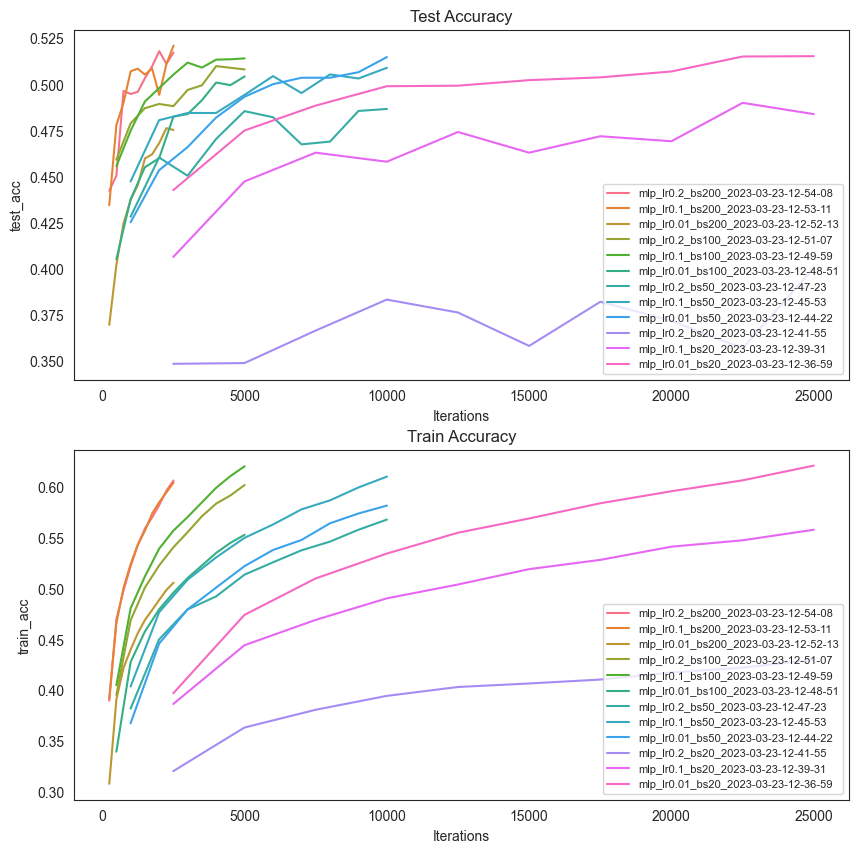

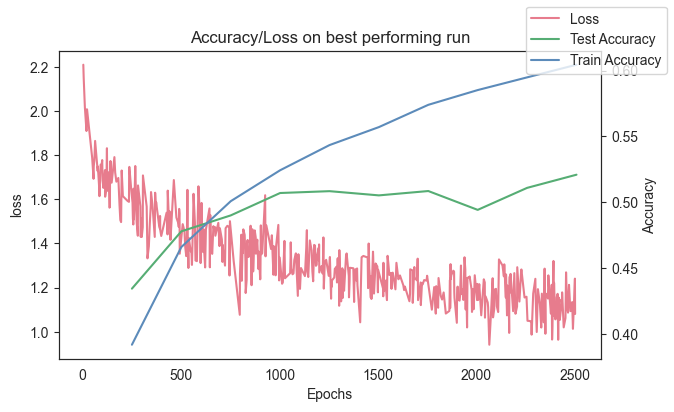

Best Test Accuracy: 0.521, with Batch Size 200 and Learning Rate 0.1, run: mlp_lr0.1_bs200_2023-03-23-12-53-11


In [46]:
summary, configs, accuracies, losses = get_logs('9m70qn3m')
nr_layers = len(configs.loc[0,'hidden_layers']) 
layers = configs.loc[0,'hidden_layers']
plot_results(summary, configs, accuracies, losses, False, f'MLP with {nr_layers} layers {layers}')

We were not able to achieve a highter accuracy score by adding one more layer. The parameter size of the model is now: 

- 1st layer: 32x32x3x256 + 256 = 814'345
- 2nd layer: 256x128 + 128 = 34'048
- 3rd layer: 128x64 + 64 = 8,256
- Output layer: 64x10 + 10 = 650
Total paremeter: 857'299

We have doubles the number of parameters, but were not able to achieve a better accuracy. This is due to the fact that the model was not able to learn the structure of the data but instead memorized the training data. We can see, that for some models if we trained for longer, the accuracy score on the training set would (probably) increase, but the accuracy score on the test set would remain the same. This is a clear sign of overfitting.

We will now try to improve the model by using convolutional layers.

**Anzahl Parameter angegeben, aussage darüber - wenn viele parameter tendenz zum overfitting**

**TorchSummary**

## Convolutional Neural Network (CNN) - Model initialization, training & evaluation

### CNN1: 2 Convolutional Layers



First we train a simple CNN with 2 convolutional layers and the same fully connetecd layers as our initial MLP. We use the ReLU activation function for the hidden layers and the softmax activation function for the output layer. In order to achieve normal distributed weights, we use Kaiming initialization.

- Number of convolutional layers: 2
- Kernel size: 5x5
- Padding: 0
- Stride: 1
- No max pooling
- No regularization
- No dropout

In [ ]:
class CNN_1(nn.Module):
    
    def __init__(self, conv1_filter, conv2_filter, kernel_size, output_size, fc1_size, fc2_size):
        super(CNN_1, self).__init__()

        self.conv1 = nn.Conv2d(3, conv1_filter, kernel_size=kernel_size) #in_channels = 3 (RGB), out_channels = no of feature maps, kernel_size = size of filter nxn
        nn.init.kaiming_normal_(self.conv1.weight, nonlinearity='relu')
        # self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, conv2_filter, kernel_size=kernel_size)
        nn.init.kaiming_normal_(self.conv2.weight, nonlinearity='relu')
        
        self.fc1 = nn.Linear(conv2_filter*24*24, fc1_size)
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        self.fc2 = nn.Linear(fc1_size, fc2_size)
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')
        self.fc3 = nn.Linear(fc2_size, output_size)
        nn.init.kaiming_normal_(self.fc3.weight, nonlinearity='relu')

    def forward(self, x): # shape if x = (batch_size, 3, 32, 32)
        x = F.relu(self.conv1(x)) # shape of x = (batch_size, 6, 28, 28)
        x = F.relu(self.conv2(x))   # shape of x = (batch_size, 16, 24, 24)
        x = x.view(-1, 16*24*24) 
        x = F.relu(self.fc1(x)) # shape of x = (batch_size, 120)
        x = F.relu(self.fc2(x)) # shape of x = (batch_size, 84)
        return self.fc3(x)    # shape of x = (batch_size, 10)
    
def train_cnn_1(config=None):
    with wandb.init(config=config) as run:

        config = wandb.config

        wandb.run.name=f'{config.architecture}_lr{config.learning_rate}_bs{config.batch_size}_{datetime.now().strftime("%Y-%m-%d-%H-%M-%S")}'

        if config.optimizer == 'sgd':
            optimizer = lambda model: torch.optim.SGD(model.parameters(), lr=config.learning_rate)
        elif config.optimizer == 'adam':
            optimizer = lambda model: torch.optim.Adam(model.parameters(), lr=config.learning_rate)

        model_training(
            modelclass=lambda: CNN_1(config.conv_filters[0], config.conv_filters[1], config.kernel_size, config.output_size, config.hidden_layers[0], config.hidden_layers[1]),
            optimizer=optimizer,
            traindata=torch.utils.data.DataLoader(cifar_train, batch_size=config.batch_size, shuffle=True),
            testdata=torch.utils.data.DataLoader(cifar_test, batch_size=config.batch_size, shuffle=True),
            criterion=nn.CrossEntropyLoss(),
            epochs=config.epochs,
            device=device
        )

sweep_config = {
    'name': 'CNN_sweep',
    'method': 'grid',
    'metric': {
        'name': 'loss',
        'goal': 'minimize'
    },
    'parameters': {
        'epochs': {
            'value': 10
            },
        'batch_size': {
            'values': [20, 50, 100, 200]
        },
        'learning_rate': {
            'values': [0.01, 0.1, 0.2]
        },
        'architecture': {
            'value': 'cnn'
        },
        'optimizer': {
            'value': 'sgd'
        },
        'loss': {
            'value': 'CrossEntropyLoss'
        },
        'activation': {
            'value': 'relu'
        },
        'hidden_layers': {
            'values': [(128, 64)]
        },
        'conv_filters': {
            'values': [(6, 16)]
        },
        'input_size': {
            'value': 32*32*3
        },
        'output_size': {
            'value': 10
        },
        'kernel_size': {
            'value': 5
        },

    }
}

sweep_id = wandb.sweep(sweep_config, project="del_mc1")
wandb.agent(sweep_id, function=train_cnn_1)

CNN with 2 convolutional layers [6, 16]


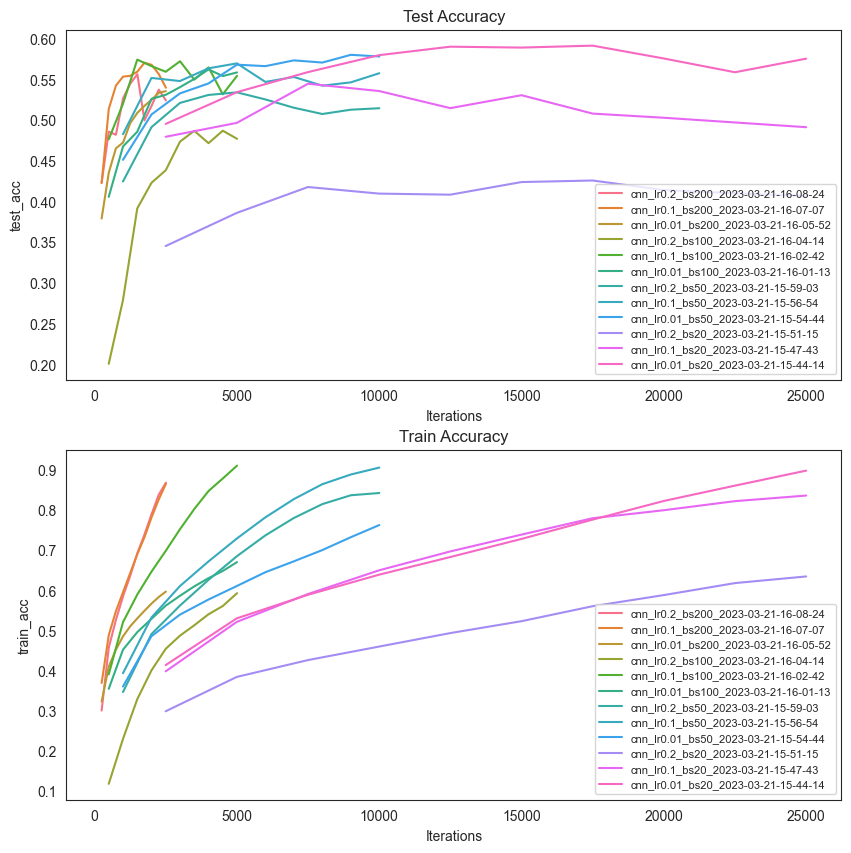

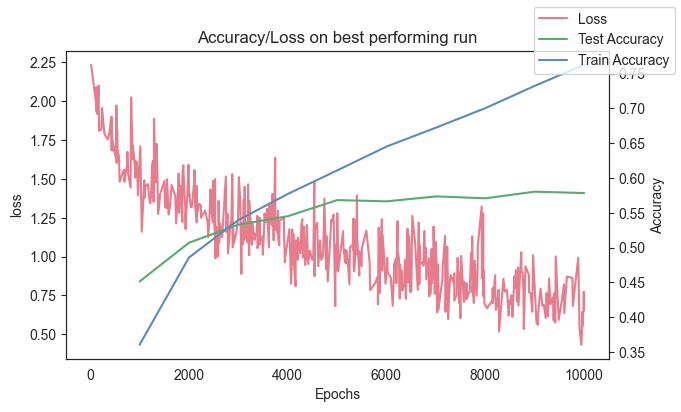

Best Test Accuracy: 0.5783, with Batch Size 50 and Learning Rate 0.01


In [18]:
summary, configs, accuracies, losses = get_logs('w077kfjd')
nr_layers = len(configs.loc[0,'hidden_layers']) 
layers = configs.loc[0,'hidden_layers']
nr_conv_layers = len(configs.loc[0,'conv_filters'])
conv_layers = configs.loc[0,'conv_filters']
plot_results(summary, configs, accuracies, losses, False, f'CNN with {nr_conv_layers} convolutional layers {conv_layers}')

We were able to increase the accuracy score by 0.05 by introducing relatively small convolutional layers. The parameter size of the model is now:

- 1st convolutional layer: 5x5x3x6 + 6 = 456 (filter size X filter size X input channels X output channels + bias terms)
- 2nd convolutional layer: 5x5x6x16 + 16 = 2'416
- 1st fully connected layer: 16*24*24*128 + 128 = 1'179'776
- 2nd fully connected layer: 64x10 + 10 = 650
Total paremeter: 1'183'298

We can see that most of the parameters are in the fully connected layers. This is due to the fact that the convolutional layers are not very deep. There is still a lot of overfitting in the model. We will try to increase the depth of the convolutional layers in the next model.





### CNN2: Increase convolutional layer size

We will now increase the size of the convolutional layers but keep the number of layers the same.

- Number of convolutional layers: 2
- Kernel size: 5x5
- Padding: 0
- Stride: 1
- No max pooling
- No regularization
- No dropout

In [9]:
class CNN_2(nn.Module):
    
    def __init__(self, conv1_filter, conv2_filter, kernel_size, output_size, fc1_size, fc2_size):
        super(CNN_2, self).__init__()

        self.conv1 = nn.Conv2d(3, conv1_filter, kernel_size=kernel_size) #in_channels = 3 (RGB), out_channels = no of feature maps, kernel_size = size of filter nxn
        nn.init.kaiming_normal_(self.conv1.weight, nonlinearity='relu')
        # self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(conv1_filter, conv2_filter, kernel_size=kernel_size)
        nn.init.kaiming_normal_(self.conv2.weight, nonlinearity='relu')
        
        self.fc1 = nn.Linear(conv2_filter*24*24, fc1_size)
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        self.fc2 = nn.Linear(fc1_size, fc2_size)
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')
        self.fc3 = nn.Linear(fc2_size, output_size)
        nn.init.kaiming_normal_(self.fc3.weight, nonlinearity='relu')

    def forward(self, x): # shape if x = (batch_size, 3, 32, 32)
        x = F.relu(self.conv1(x)) # shape of x = (batch_size, 32, 28, 28)
        x = F.relu(self.conv2(x))   # shape of x = (batch_size, 128, 24, 24)
        x = x.view(-1, 128*24*24) 
        x = F.relu(self.fc1(x)) # shape of x = (batch_size, 120)
        x = F.relu(self.fc2(x)) # shape of x = (batch_size, 84)
        return self.fc3(x)    # shape of x = (batch_size, 10)
    
def train_cnn_2(config=None):
    with wandb.init(config=config) as run:

        config = wandb.config

        wandb.run.name=f'{config.architecture}_lr{config.learning_rate}_bs{config.batch_size}_{datetime.now().strftime("%Y-%m-%d-%H-%M-%S")}'

        if config.optimizer == 'sgd':
            optimizer = lambda model: torch.optim.SGD(model.parameters(), lr=config.learning_rate)
        elif config.optimizer == 'adam':
            optimizer = lambda model: torch.optim.Adam(model.parameters(), lr=config.learning_rate)

        model_training(
            modelclass=lambda: CNN_2(config.conv_filters[0], config.conv_filters[1], config.kernel_size, config.output_size, config.hidden_layers[0], config.hidden_layers[1]),
            optimizer=optimizer,
            traindata=torch.utils.data.DataLoader(cifar_train, batch_size=config.batch_size, shuffle=True),
            testdata=torch.utils.data.DataLoader(cifar_test, batch_size=config.batch_size, shuffle=True),
            criterion=nn.CrossEntropyLoss(),
            epochs=config.epochs,
            device=device
        )

sweep_config = {
    'name': 'CNN_sweep',
    'method': 'grid',
    'metric': {
        'name': 'loss',
        'goal': 'minimize'
    },
    'parameters': {
        'epochs': {
            'value': 10
            },
        'batch_size': {
            'values': [20, 50, 100]
        },
        'learning_rate': {
            'values': [0.01, 0.1, 0.2]
        },
        'architecture': {
            'value': 'cnn'
        },
        'optimizer': {
            'value': 'sgd'
        },
        'loss': {
            'value': 'CrossEntropyLoss'
        },
        'activation': {
            'value': 'relu'
        },
        'hidden_layers': {
            'values': [(128, 64)]
        },
        'conv_filters': {
            'values': [(32, 128)]
        },
        'input_size': {
            'value': 32*32*3
        },
        'output_size': {
            'value': 10
        },
        'kernel_size': {
            'value': 5
        },

    }
}

sweep_id = wandb.sweep(sweep_config, project="del_mc1")
wandb.agent(sweep_id, function=train_cnn_2)

Create sweep with ID: 8gf9kkm0
Sweep URL: https://wandb.ai/lukas_fhnw/del_mc1/sweeps/8gf9kkm0


wandb: Agent Starting Run: ertpc0qy with config:
wandb: 	activation: relu
wandb: 	architecture: cnn
wandb: 	batch_size: 20
wandb: 	conv_filters: [32, 128]
wandb: 	epochs: 10
wandb: 	hidden_layers: [128, 64]
wandb: 	input_size: 3072
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.01
wandb: 	loss: CrossEntropyLoss
wandb: 	optimizer: sgd
wandb: 	output_size: 10
wandb: Network error (ConnectionError), entering retry loop.


CNN with 2 convolutional layers [32, 128]


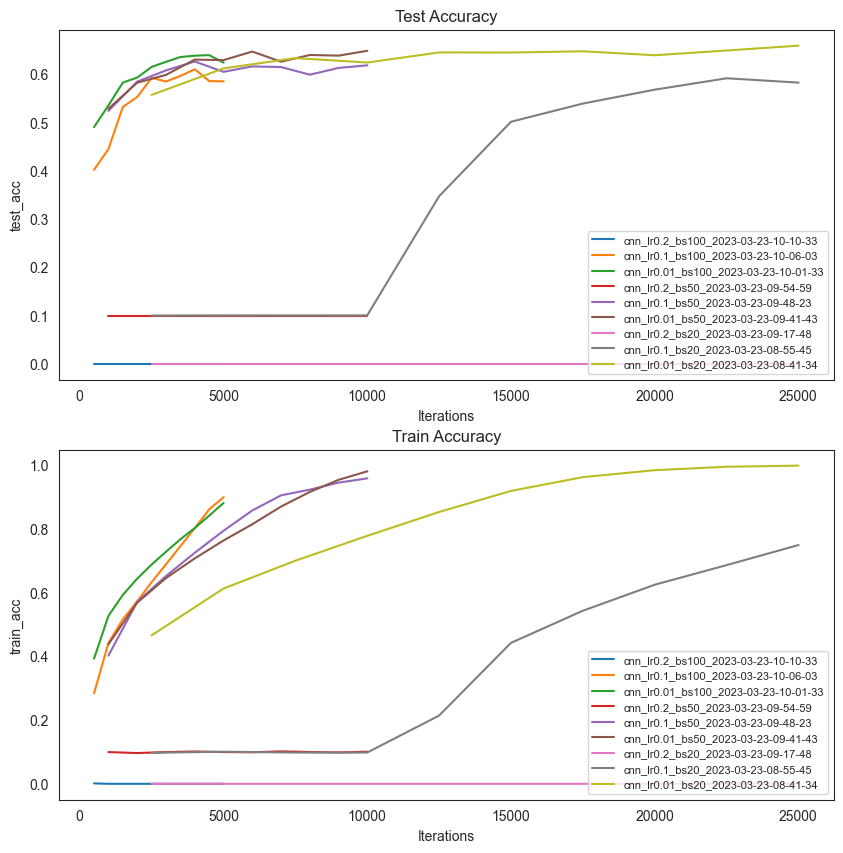

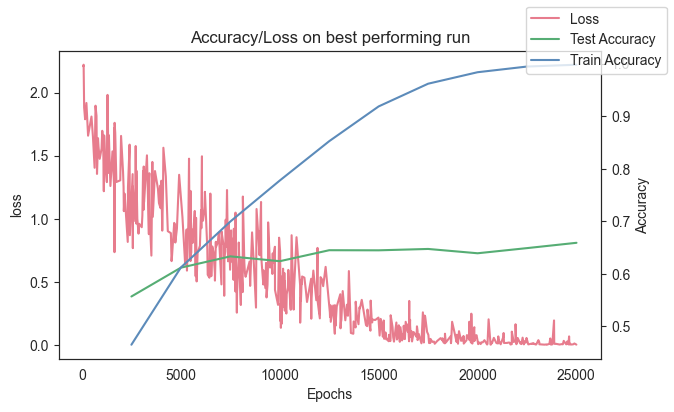

Best Test Accuracy: 0.6591, with Batch Size 20 and Learning Rate 0.01


In [20]:
summary, configs, accuracies, losses = get_logs('8gf9kkm0')
nr_layers = len(configs.loc[0,'hidden_layers']) 
layers = configs.loc[0,'hidden_layers']
nr_conv_layers = len(configs.loc[0,'conv_filters'])
conv_layers = configs.loc[0,'conv_filters']
plot_results(summary, configs, accuracies, losses, False, f'CNN with {nr_conv_layers} convolutional layers {conv_layers}')

The accuracy of this model increased by almost 0.08 compared to the previous model. This is a huge improvement. 


The training time for this model also increased significantly.


### Dense Layer durch Convolutional Layer ersetzen

### CNN3: Using Max Pooling

We will now add max pooling to our model. Max pooling is a technique used to reduce the spatial size of the input. It is used to reduce the number of parameters and computation in the network, and therefore to also control overfitting.

Since we were not able to achieve a better accuracy with larger convolutional layers, we will return to the original size of the convolutional layers.


**CHECK SIZE OF CONVOLUTIONAL LAYERS**

In [27]:
class CNN_2(nn.Module):
    
    def __init__(self, conv1_filter, conv2_filter, kernel_size, output_size, fc1_size, fc2_size):
        super(CNN_2, self).__init__()

        self.conv1 = nn.Conv2d(3, conv1_filter, kernel_size=kernel_size) #in_channels = 3 (RGB), out_channels = no of feature maps, kernel_size = size of filter nxn
        nn.init.kaiming_normal_(self.conv1.weight, nonlinearity='relu')
        self.pool = nn.MaxPool2d(kernelsize=2, stride=2)
        self.conv2 = nn.Conv2d(conv1_filter, conv2_filter, kernel_size=kernel_size)
        nn.init.kaiming_normal_(self.conv2.weight, nonlinearity='relu')
        
        self.fc1 = nn.Linear(conv2_filter*5*5, fc1_size)
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        self.fc2 = nn.Linear(fc1_size, fc2_size)
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')
        self.fc3 = nn.Linear(fc2_size, output_size)
        nn.init.kaiming_normal_(self.fc3.weight, nonlinearity='relu')

    def forward(self, x): # shape if x = (batch_size, 3, 32, 32)
        x = self.pool(F.relu(self.conv1(x))) # shape of x = (batch_size, 32, 14, 14)
        x = self.pool(F.relu(self.conv2(x)))   # shape of x = (batch_size, 128, 5, 5)
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x)) # shape of x = (batch_size, 120)
        x = F.relu(self.fc2(x)) # shape of x = (batch_size, 84)
        return self.fc3(x)    # shape of x = (batch_size, 10)
    
def train_cnn_2(config=None):
    with wandb.init(config=config) as run:

        config = wandb.config

        wandb.run.name=f'{config.architecture}_lr{config.learning_rate}_bs{config.batch_size}_{datetime.now().strftime("%Y-%m-%d-%H-%M-%S")}'

        if config.optimizer == 'sgd':
            optimizer = lambda model: torch.optim.SGD(model.parameters(), lr=config.learning_rate)
        elif config.optimizer == 'adam':
            optimizer = lambda model: torch.optim.Adam(model.parameters(), lr=config.learning_rate)

        model_training(
            modelclass=lambda: CNN_2(config.conv_filters[0], config.conv_filters[1], config.kernel_size, config.output_size, config.hidden_layers[0], config.hidden_layers[1]),
            optimizer=optimizer,
            traindata=torch.utils.data.DataLoader(cifar_train, batch_size=config.batch_size, shuffle=True),
            testdata=torch.utils.data.DataLoader(cifar_test, batch_size=config.batch_size, shuffle=True),
            criterion=nn.CrossEntropyLoss(),
            epochs=config.epochs,
            device=device
        )

sweep_config = {
    'name': 'CNN_sweep',
    'method': 'grid',
    'metric': {
        'name': 'loss',
        'goal': 'minimize'
    },
    'parameters': {
        'epochs': {
            'value': 10
            },
        'batch_size': {
            'values': [20, 50, 100]
        },
        'learning_rate': {
            'values': [0.01, 0.1, 0.2]
        },
        'architecture': {
            'value': 'cnn'
        },
        'optimizer': {
            'value': 'sgd'
        },
        'loss': {
            'value': 'CrossEntropyLoss'
        },
        'activation': {
            'value': 'relu'
        },
        'hidden_layers': {
            'values': [(128, 64)]
        },
        'conv_filters': {
            'values': [(6, 16)]
        },
        'input_size': {
            'value': 32*32*3
        },
        'output_size': {
            'value': 10
        },
        'kernel_size': {
            'value': 5
        },

    }
}

sweep_id = wandb.sweep(sweep_config, project="del_mc1")
wandb.agent(sweep_id, function=train_cnn_2)


Create sweep with ID: rv4ae265
Sweep URL: https://wandb.ai/lukas_fhnw/del_mc1/sweeps/rv4ae265


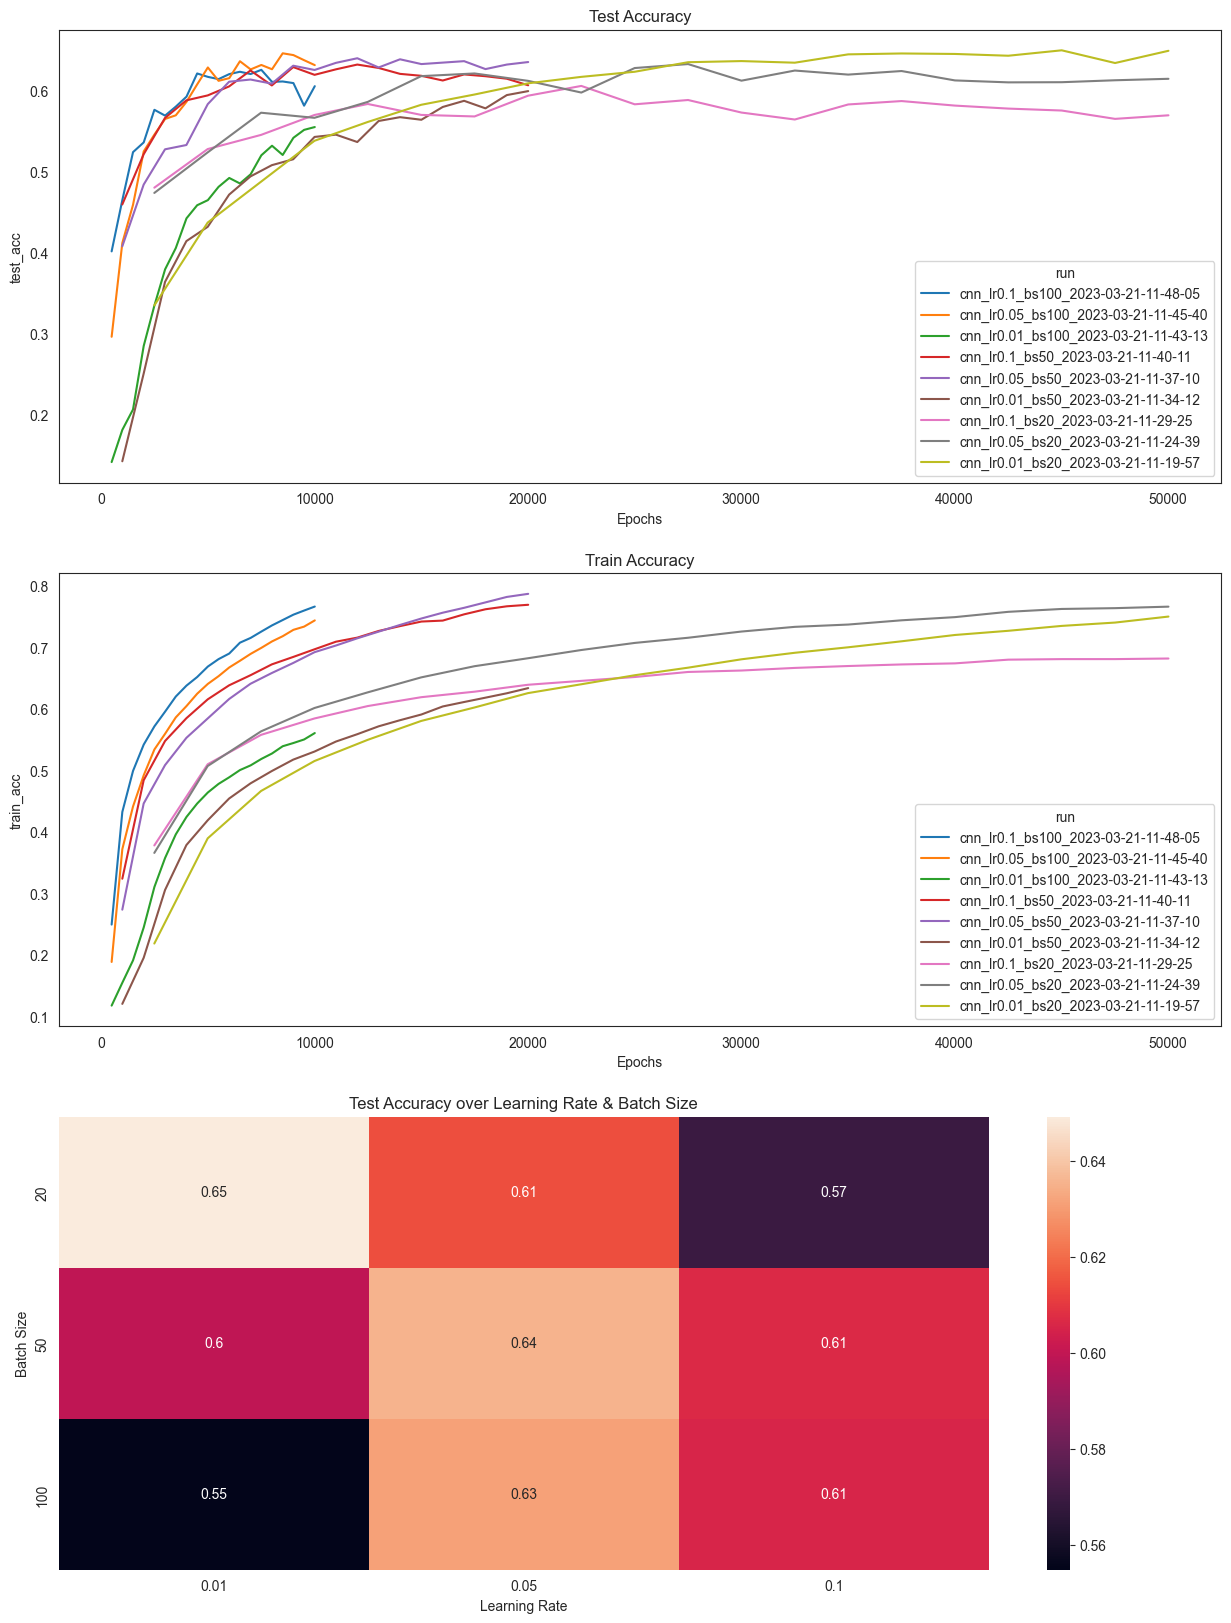

Best Test Accuracy: 0.6491, with Batch Size 20 and Learning Rate 0.01


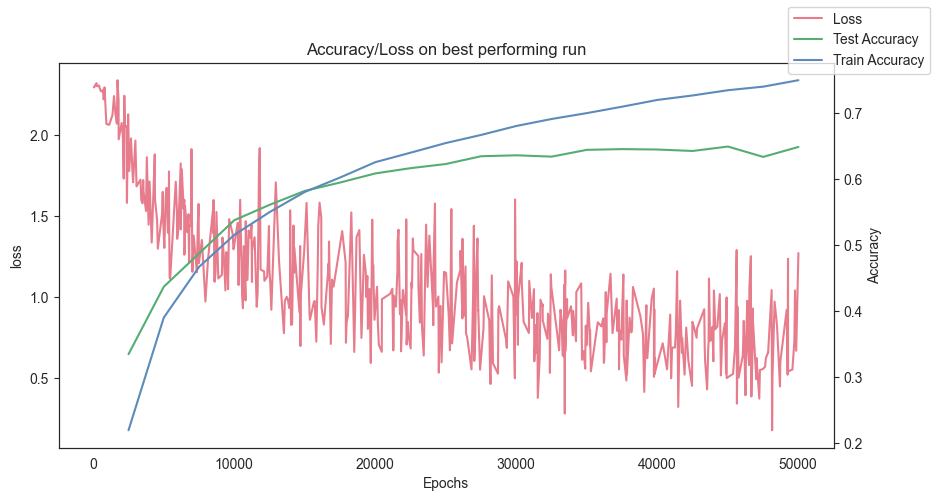

In [28]:
summary, configs, accuracies, losses = get_logs(sweep_ids[-1])
plot_results(summary, configs, accuracies, losses)

### CNN4: Adding Dropout

Machen auf Modell welches overfittet

### CNN5: Adjusting Stride, Padding & Kernel Size


### CNN6: Increase number of convolutional layers

### CNN8: Adding Batch Normalization

Braucht gewisse tiefe um zu funktionieren

### ADAM Optimizer

# Evaluation

## Cross Validation / Standard Deviation Error